# Figure 1. Read counts for for biological WT replicates

Code for making Figure 1 in the Nanopore DRS paper *Native long-read RNA sequencing of the Arabidopsis thaliana transcriptome*. For this figure we're focussing on two datasets; first, four biological replicates of WT col-0 tissue and second, two datasets examining the impact and addition of a 5' cap for identifying full length mRNA isoforms.

The first figure in the paper is there to highlight that a single sequencing run captures asimilar level of RNA complexity and existing gold-standard annotation. Here I load the data for all the datasets and the existing araport and AtRTD2 annotations and plot the read length histograms.

In [1]:
import pysam, numpy

def getReadLengths(bamfile):
    print("Reading data from file {}...".format(bamfile))
    thisbam = pysam.AlignmentFile(bamfile, "rb")
    readids=[]
    alignedlens=[]
    for read in thisbam.fetch():
        alignedlens.append(read.query_alignment_length)
        readids.append(read.query_name)

    alignedlens=numpy.array(alignedlens)
    readids=numpy.array(readids)
    print("\tread length information for {} reads.".format(len(readids)))
    return((readids, alignedlens))

In [8]:
# extract the read length information for each of the datasets
import os, re
bam_files = {"col0_rep1":{"bamfile":"201901_col0_2916.bam",
                          "path":"../../datasets/20180201_1617_20180201_FAH45730_WT_Col0_2916_regular_seq"},
             "col0_rep2a":{"bamfile":"201903_col0_2917_exp2.bam",
                          "path":"../../datasets/2020180405_FAH59362_WT_Col0_2917"},
             "col0_rep2b":{"bamfile":"201901_col0_2917.bam",
                          "path":"../../datasets/20180413_1558_20180413_FAH77434_mRNA_WT_Col0_2917"},
             "col0_rep3":{"bamfile":"201901_col0_2918.bam",
                          "path":"../../datasets/20180416_1534_20180415_FAH83697_mRNA_WT_Col0_2918"},
             "col0_rep4":{"bamfile":"201901_col0_2919.bam",
                          "path":"../../datasets/20180418_1428_20180418_FAH83552_mRNA_WT_Col0_2919"},
             "col0_5padapter_rep1":{"bamfile":"201902_col0_2916_5adapter_exp2.bam",
                                    "path":"../../datasets/20180411_1432_20180911_FAH84603_5adapterLIG_Col0_2916"},
             "col0_5padapter_rep2":{"bamfile":"201902_col0_2918_5adapter.bam",
                                    "path":"../../datasets/20180508_1522_20180508_FAH82422_5adapt_lig_mRNA_2918"}}

read_lengths={}
for keystr in bam_files.keys():
    fullpath = os.path.join(bam_files[keystr]["path"], "aligned_data/TAIR10/",
                            bam_files[keystr]["bamfile"])
    read_lengths[keystr] = getReadLengths(fullpath)

Reading data from file ../../datasets/20180201_1617_20180201_FAH45730_WT_Col0_2916_regular_seq/aligned_data/TAIR10/201901_col0_2916.bam...
	read length information for 1003137 reads.
Reading data from file ../../datasets/2020180405_FAH59362_WT_Col0_2917/aligned_data/TAIR10/201903_col0_2917_exp2.bam...
	read length information for 743684 reads.
Reading data from file ../../datasets/20180413_1558_20180413_FAH77434_mRNA_WT_Col0_2917/aligned_data/TAIR10/201901_col0_2917.bam...
	read length information for 930629 reads.
Reading data from file ../../datasets/20180416_1534_20180415_FAH83697_mRNA_WT_Col0_2918/aligned_data/TAIR10/201901_col0_2918.bam...
	read length information for 757028 reads.
Reading data from file ../../datasets/20180418_1428_20180418_FAH83552_mRNA_WT_Col0_2919/aligned_data/TAIR10/201901_col0_2919.bam...
	read length information for 765322 reads.
Reading data from file ../../datasets/20180411_1432_20180911_FAH84603_5adapterLIG_Col0_2916/aligned_data/TAIR10/201902_col0_2916_

In [9]:
# We're going to merge the results for two runs of tissue 2917 because these are the same sample
# sequenced twice due to an unforseen laptop reboot for updates (ahhh windows, how I love thee!)
read_lengths["col0_rep2"] = (numpy.concatenate((read_lengths["col0_rep2a"][0],
                                                read_lengths["col0_rep2b"][0]),
                                                axis=None),
                             numpy.concatenate((read_lengths["col0_rep2a"][1],
                                                read_lengths["col0_rep2b"][1]),
                                                axis=None))
del read_lengths["col0_rep2a"]
del read_lengths["col0_rep2b"]

In [12]:
# load the length information for the existing annotations
from Bio import SeqIO
araport_fasta = "../../annotations/Araport/Araport11_genes.201606.cdna.fasta"
araport_lens=[]
araport_ids=[]
for record in SeqIO.parse(araport_fasta, "fasta"):
    thislen = len(record.seq)
    araport_lens.append(thislen)
    araport_ids.append(record.id)
araport_lens = numpy.array(araport_lens)
araport_ids = numpy.array(araport_ids)

atRTD_fasta = "../../annotations/AtRTD/AtRTD2_19April2016.fa"
atRTD_lens=[]
atRTD_ids=[]
for record in SeqIO.parse(atRTD_fasta, "fasta"):
    thislen = len(record.seq)
    atRTD_lens.append(thislen)
    atRTD_ids.append(record.id)
atRTD_lens = numpy.array(atRTD_lens)
atRTD_ids = numpy.array(atRTD_ids)

/cluster/gjb_lab/nschurch/cluster_installs/miniconda2/envs/python3.6.4/lib/python3.6/site-packages/ipykernel_launcher.py:36: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


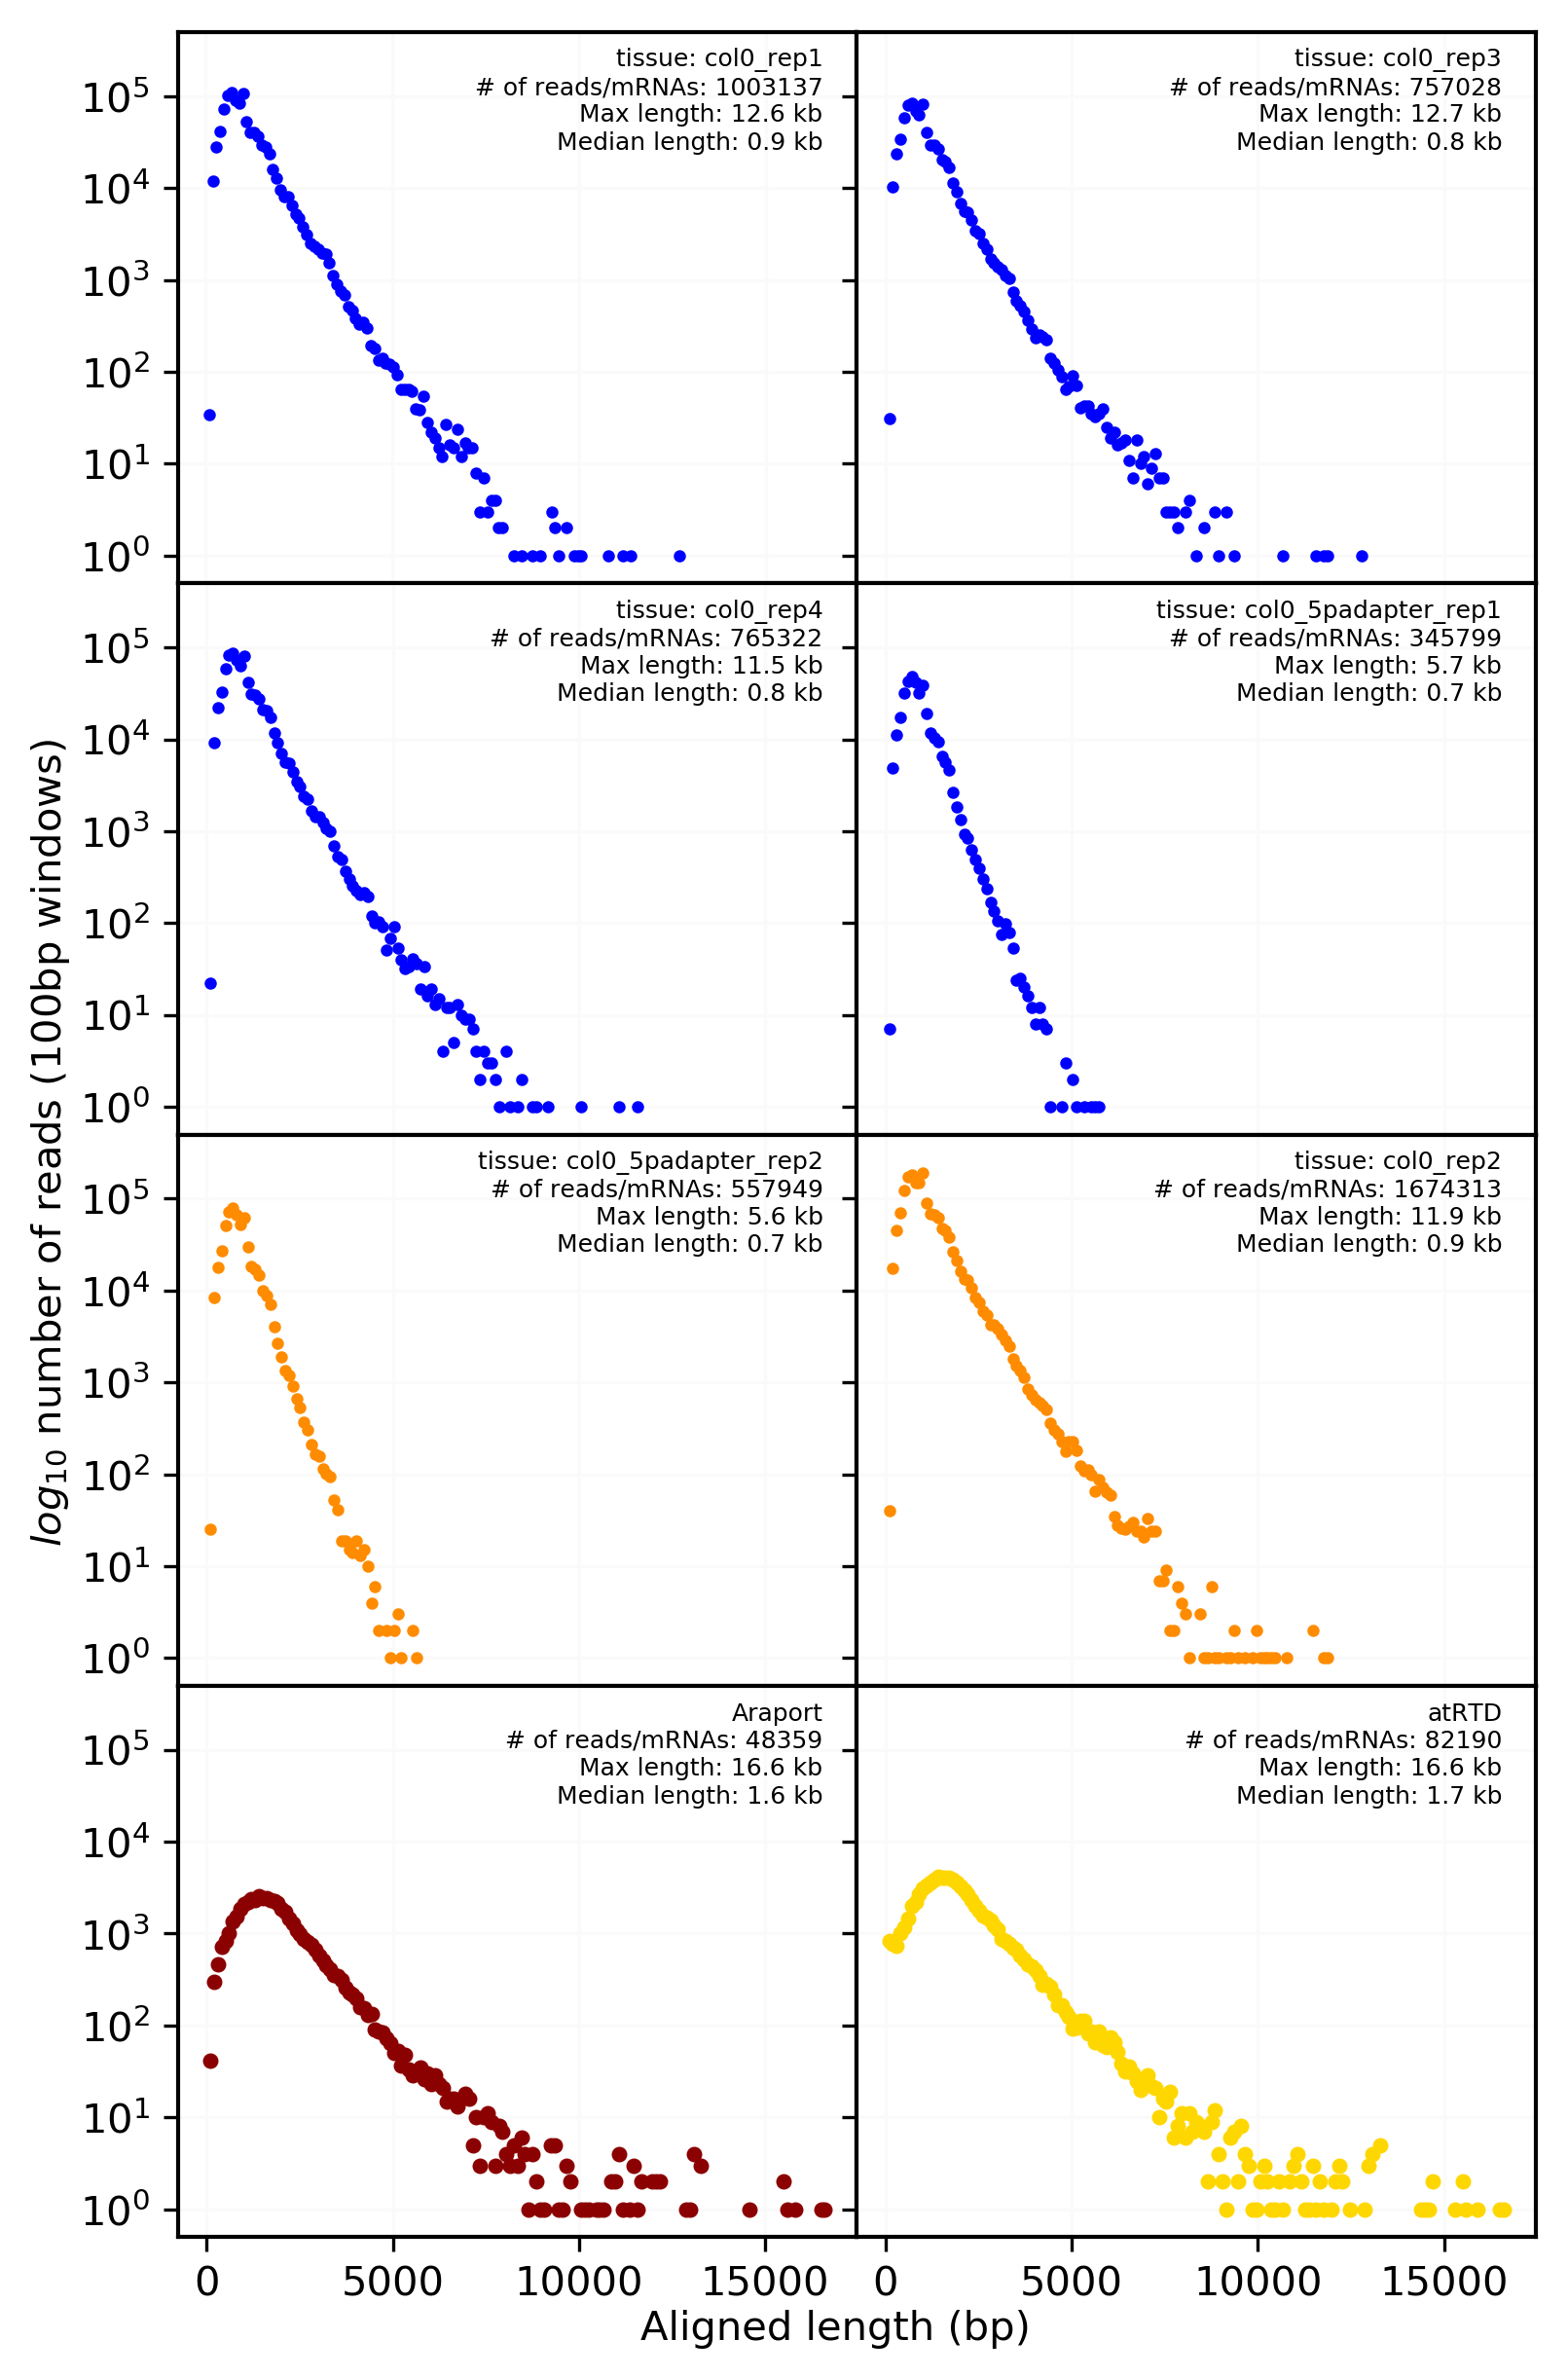

In [14]:
# Make plot
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['axes.linewidth'] = 1
plt.rcParams['svg.fonttype'] = 'none'

def plotScatterHist(plot_index, data, bins, label, sharex, sharey, color=None, rows=4,
                    cols=2, s=8, fontsize=6, showxlabels=True):
    ax = plt.subplot(rows, cols, plot_index, sharex=sharex, sharey=sharey)
    rlhist = numpy.histogram(data, bins)
    if color is None:
        color='blue'
    plt.ylim(0.5,500000)
    if sharey is None:
        ax.set_yscale("log")
    else:
        plt.setp(ax.get_yticklabels(), visible=False)
    if not showxlabels:
        plt.setp(ax.get_xticklabels(), visible=False)
    ax.text(0.95, 0.95, label, ha='right', va='center',
            transform=ax.transAxes, fontsize=fontsize)
    ax.text(0.95, 0.9, "# of reads/mRNAs: {}".format(len(data)), ha='right',
            va='center', transform=ax.transAxes, fontsize=fontsize)
    ax.text(0.95, 0.85, "Max length: {:.1f} kb".format(data.max()/1E3), ha='right',
            va='center', transform=ax.transAxes, fontsize=fontsize)
    ax.text(0.95, 0.80, "Median length: {:.1f} kb".format(int(numpy.median(data))/1E3), ha='right',
            va='center', transform=ax.transAxes, fontsize=fontsize)
    plt.grid(color='0.98', linestyle='-', zorder=1)
    plt.minorticks_off()
    plt.scatter(rlhist[1][1:], rlhist[0], s=s, label=label, color=color, zorder=2)
    return(ax)

fig1 = plt.figure(figsize=(6,10), dpi=300)
subplot_index=1
bins=numpy.linspace(1,16600,16600/100)
axes=[]
for dataset in read_lengths.keys():
    if subplot_index == 1:
        sharey=None
        sharex=None
    elif subplot_index == 2:
        sharey=axes[0]
        sharex=None
    elif subplot_index == 3 or subplot_index == 5:
        sharey=None
        sharex=axes[subplot_index-2]
    else:
        sharey=axes[subplot_index-2]
        sharex=axes[subplot_index-2]
    plotlabel = "tissue: {}".format(re.sub("run.+_tissue","",dataset))
    
    color='blue'
    if subplot_index == 5 or subplot_index == 6:
        color='darkorange'
    ax = plotScatterHist(subplot_index, read_lengths[dataset][1], bins, plotlabel,
                         sharex, sharey, s=4, color=color, showxlabels=False)
    plt.subplots_adjust(hspace=.0, wspace=.0)
    axes.append(ax)
    subplot_index+=1

# add araport plot
ax = plotScatterHist(subplot_index, araport_lens, bins, "Araport",
                     axes[subplot_index-2], None, color='darkred')
axes.append(ax)
subplot_index+=1

# add atRTD
ax = plotScatterHist(subplot_index, atRTD_lens, bins, "atRTD",
                     axes[subplot_index-2], axes[subplot_index-2], color='gold')
axes.append(ax)

xlabel = fig1.text(0.5, 0.09, "Aligned length (bp)", ha='center')
ylabel = fig1.text(0.04, 0.5, r"$log_{10}$ number of reads (100bp windows)",
                   va='center', rotation='vertical')

/cluster/gjb_lab/nschurch/cluster_installs/miniconda2/envs/python3.6.4/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  after removing the cwd from sys.path.


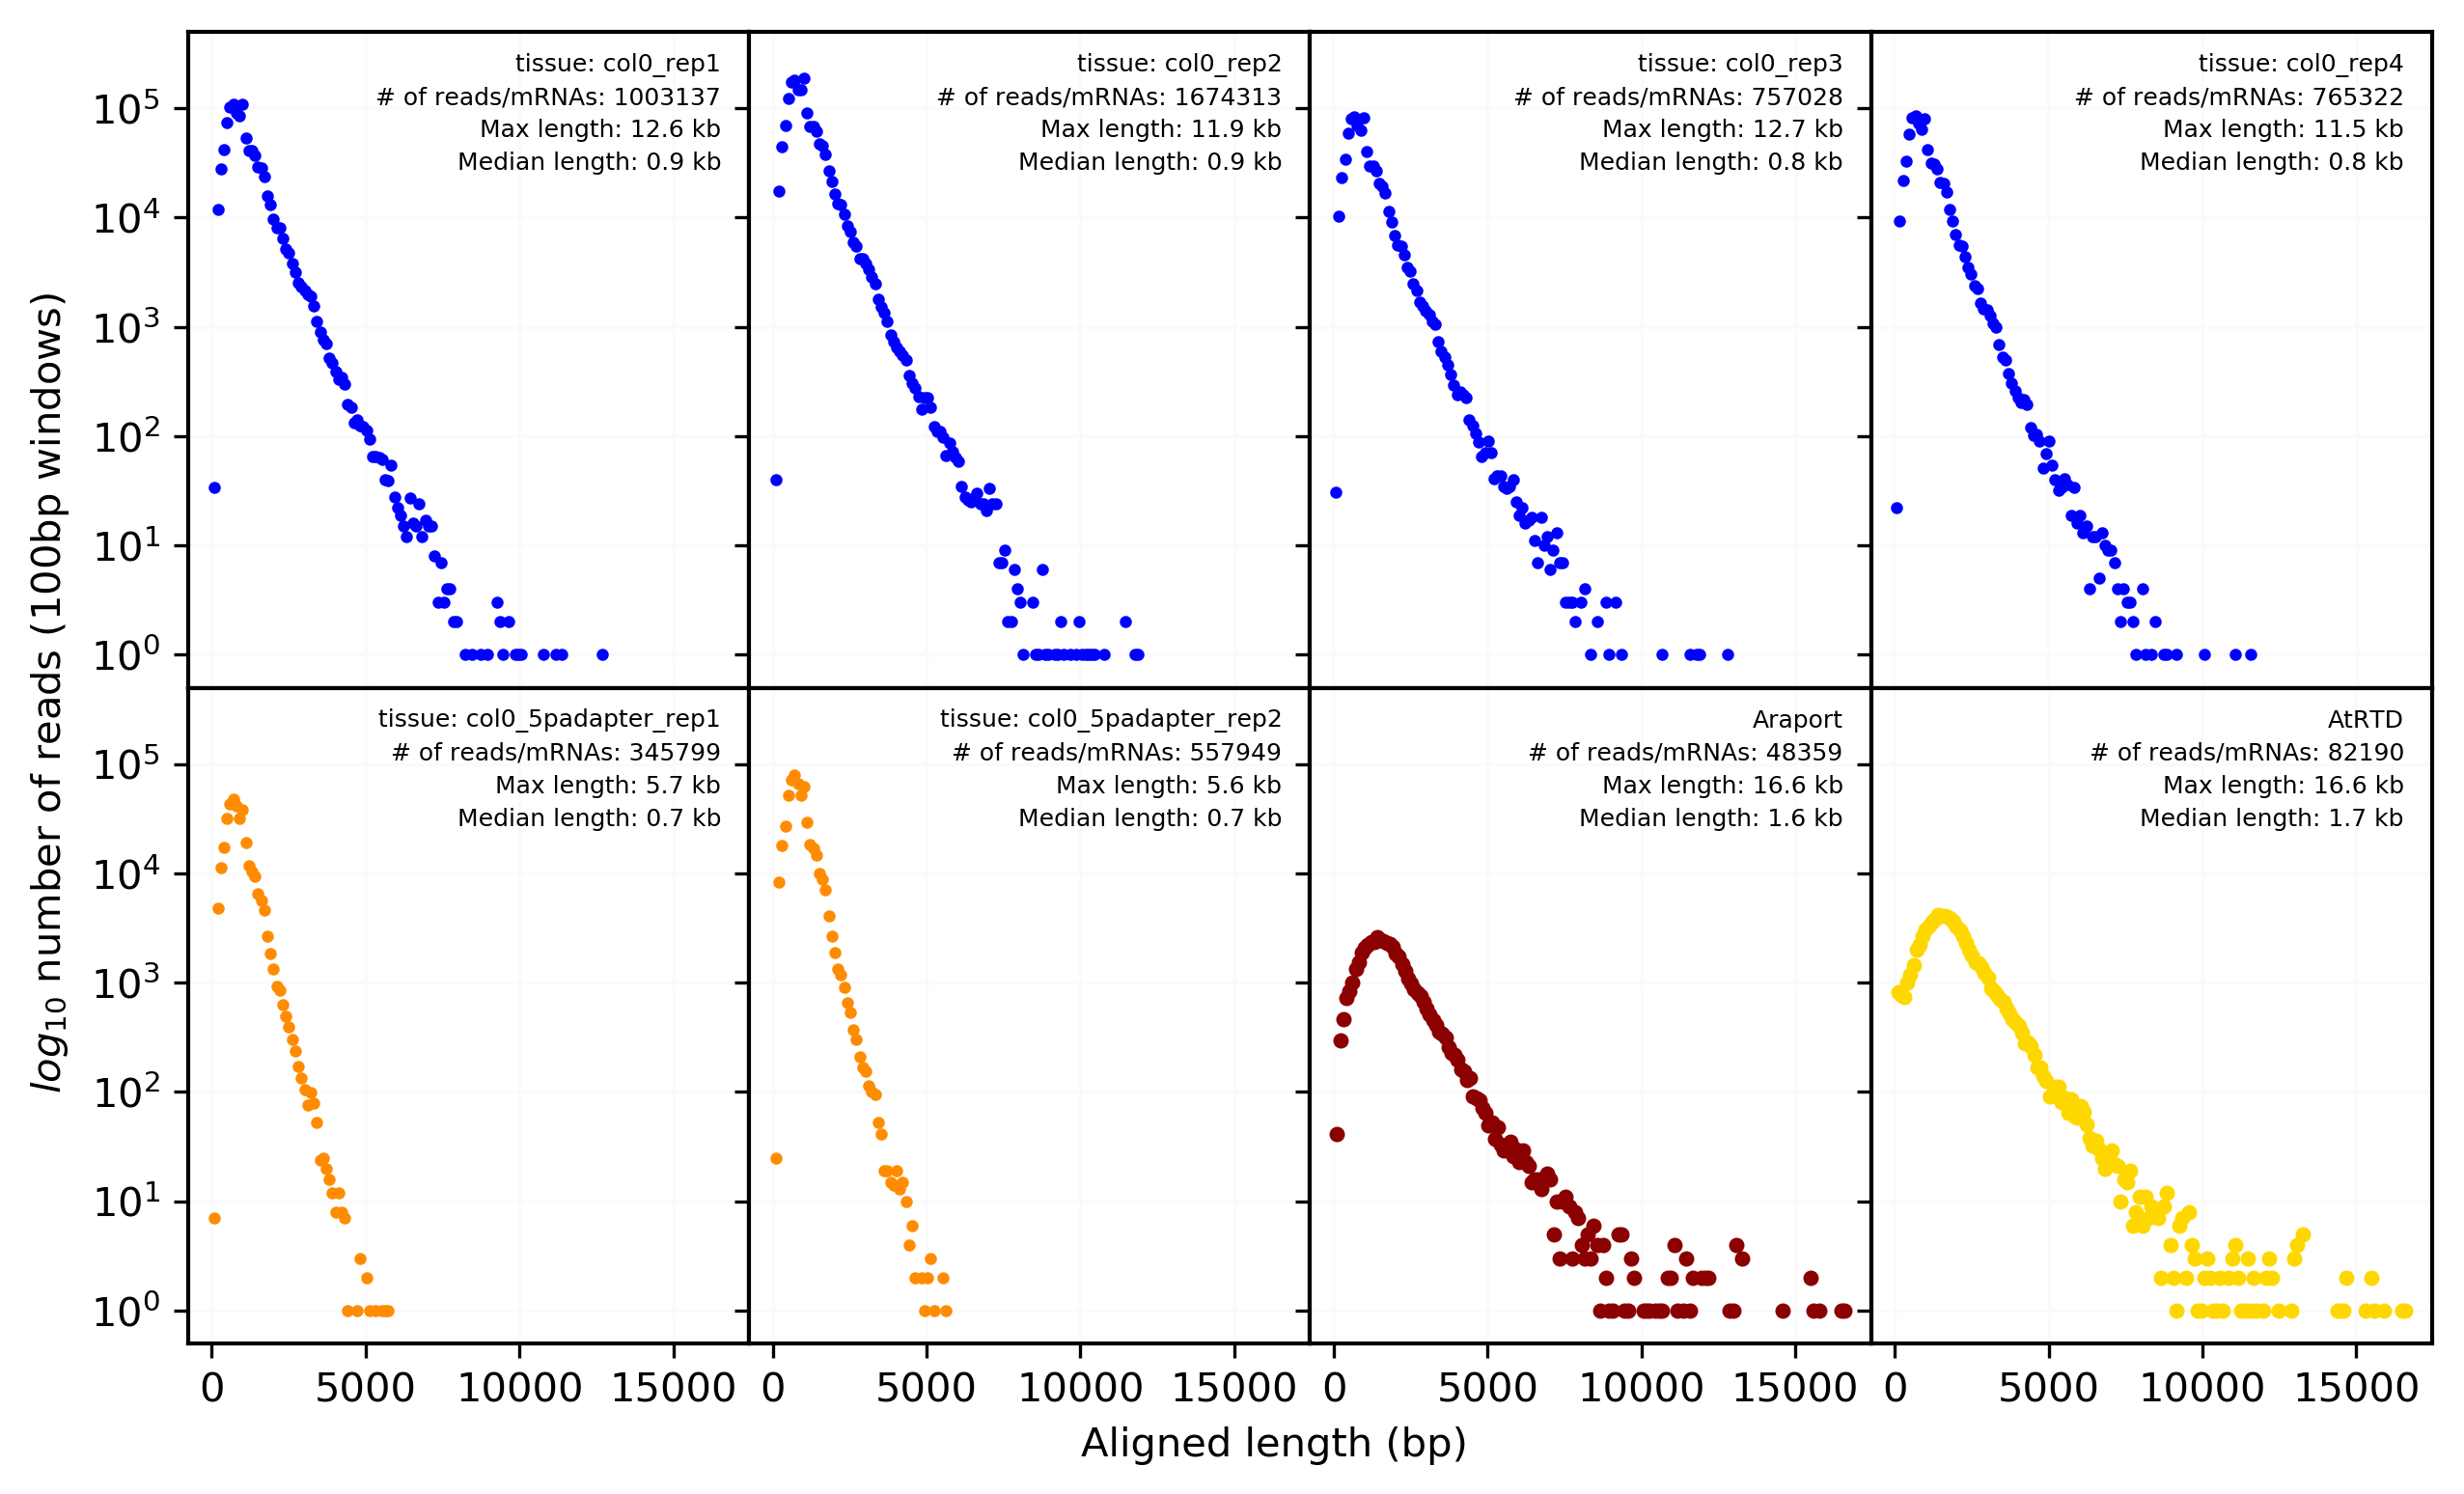

In [21]:
# I think this plot is better horizontal....
fig1 = plt.figure(figsize=(10,6), dpi=300)
subplot_index=1
bins=numpy.linspace(1,16600,16600/100)
axes=[]
showxlabels=False
plotorder = ['col0_rep1','col0_rep2','col0_rep3','col0_rep4',
             'col0_5padapter_rep1', 'col0_5padapter_rep2']
for dataset in plotorder:
    if subplot_index == 1:
        sharey=None
        sharex=None
    elif subplot_index in [2,3,4]:
        sharey=axes[0]
        sharex=None
    elif subplot_index == 5:
        sharey=None
        sharex=axes[subplot_index-5]
    else:
        sharey=axes[4]
        sharex=axes[subplot_index-5]
    plotlabel = "tissue: {}".format(re.sub("run.+_tissue","",dataset))
    
    color='blue'
    if subplot_index == 5 or subplot_index == 6:
        color='darkorange'
        showxlabels=True
    ax = plotScatterHist(subplot_index, read_lengths[dataset][1], bins, plotlabel,
                         sharex, sharey, s=4, color=color, showxlabels=showxlabels, rows=2,
                         cols=4)
    plt.subplots_adjust(hspace=.0, wspace=.0)
    axes.append(ax)
    subplot_index+=1

# add araport plot
ax = plotScatterHist(subplot_index, araport_lens, bins, "Araport",
                     axes[subplot_index-2], axes[4], color='darkred',
                     rows=2, cols=4)
axes.append(ax)
subplot_index+=1

# add atRTD
ax = plotScatterHist(subplot_index, atRTD_lens, bins, "AtRTD",
                     axes[subplot_index-2], axes[4], color='gold',
                     rows=2, cols=4)
axes.append(ax)

xlabel = fig1.text(0.5, 0.06, "Aligned length (bp)", ha='center')
ylabel = fig1.text(0.07, 0.5, r"$log_{10}$ number of reads (100bp windows)",
                   va='center', rotation='vertical')

plt.savefig("../figures/Figure_01.svg", format='svg', bbox_inches='tight', frameon=False)
plt.savefig("../figures/Figure_01.png", format='png', dpi=300, transparent=True, format='png',
            bbox_inches='tight', frameon=False)

In [23]:
for dataset in sorted(list(read_lengths.keys())):
    maxlenind = numpy.where(read_lengths[dataset][1]==read_lengths[dataset][1].max())[0]
    print("{} maximum read length: {} ({})".format(dataset, read_lengths[dataset][1].max(),
                                                    read_lengths[dataset][0][maxlenind]))
    print("{} mean read length: {:.2f}".format(dataset, read_lengths[dataset][1].mean()))
    print("{} median read length: {}\n".format(dataset, numpy.median(read_lengths[dataset][1])))

col0_5padapter_rep1 maximum read length: 5663 (['9bbfac56-fe48-48ea-85b7-de7180e7140d'])
col0_5padapter_rep1 mean read length: 816.40
col0_5padapter_rep1 median read length: 737.0

col0_5padapter_rep2 maximum read length: 5596 (['ffd95180-6a38-4496-8aaa-9214595aea2f'])
col0_5padapter_rep2 mean read length: 807.44
col0_5padapter_rep2 median read length: 731.0

col0_rep1 maximum read length: 12607 (['d0211713-a551-4bb6-982a-e65b4b660aa0'])
col0_rep1 mean read length: 989.49
col0_rep1 median read length: 864.0

col0_rep2 maximum read length: 11852 (['d30c72ad-7056-4e36-b3d9-793c576b3f39'])
col0_rep2 mean read length: 988.32
col0_rep2 median read length: 866.0

col0_rep3 maximum read length: 12744 (['dde20fe6-ac51-4411-8047-5d133182678a'])
col0_rep3 mean read length: 961.63
col0_rep3 median read length: 837.0

col0_rep4 maximum read length: 11542 (['a0e7baf6-a037-4d08-9cc2-7a3a574d998b'])
col0_rep4 mean read length: 962.45
col0_rep4 median read length: 838.0



In [24]:
dataset = (araport_ids, araport_lens)
maxlenind = numpy.where(dataset[1]==dataset[1].max())[0]
print("araport maximum read length: {} ({})".format(dataset[1].max(), dataset[0][maxlenind]))
print("araport mean read length: {:.2f}".format(dataset[1].mean()))
print("araport median read length: {}".format(numpy.median(dataset[1])))
print("# araport transcripts>12.5kb: {}\n".format(sum(dataset[1]>12000)))

araport maximum read length: 16593 (['AT1G67120.1'])
araport mean read length: 1787.55
araport median read length: 1595.0
# araport transcripts>12.5kb: 18



In [25]:
dataset = (atRTD_ids, atRTD_lens)
maxlenind = numpy.where(dataset[1]==dataset[1].max())[0]
print("atRTD maximum read length: {} ({})".format(dataset[1].max(), dataset[0][maxlenind]))
print("atRTD mean read length: {:.2f}".format(dataset[1].mean()))
print("atRTD median read length: {}".format(numpy.median(dataset[1])))
print("# atRTD transcripts>12.5kb: {}\n".format(sum(dataset[1]>12000)))

atRTD maximum read length: 16593 (['AT1G67120_P1'])
atRTD mean read length: 1858.14
atRTD median read length: 1663.0
# atRTD transcripts>12.5kb: 31

